L'industria degli idrocarburi sta ultimamente investendo molto per l'identificazione delle regioni contenenti sale nel sottosuolo. Infatti tali sedimenti salini spesso portano alla creazione di "trappole" per gli idrocarburi ([per maggiori informazioni](https://www.sciencedirect.com/science/article/pii/S0264817214003717)).<br/>
Scopo di questo notebook è utilizzare una U-net per andare ad identificare le aree delle immagini fornite che contengono tali depositi salini. Le immagini utilizzate sono ottenute grazie a metodi di sismica a riflessione. Si tratta di immagini 2D dove l'asse delle y rappresenta il tempo (e quindi fornisce direttamente informazioni sulla profondità), mentre l'asse delle x rappresenta la posizione nel terreno.<br/>
![](https://wiki.seg.org/images/0/04/Salt_diapir_with_disorderly_data.jpg)<br/>
Vengono inoltre fornite le relative immagini(maschere) che evidenziano la localizzazione dei depositi.  Le aree completamente bianche di queste immagini indicano la presenza di sale.<br/>
[Ulteriori informazioni](http://deeplearning.net/tutorial/unet.html) sulle U-net.<br/><br/> Per velocizzare l'esecuzione del programma, ho caricato direttamente il notebook su kaggle. I dati utilizzati possono essere trovati [qui](https://www.kaggle.com/c/tgs-salt-identification-challenge/overview).

In [73]:
# come prima cosa importo le librerie
import os
import random
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from tqdm import tqdm_notebook, tnrange

from skimage.transform import resize
from skimage.io import imread, imshow, imread_collection, concatenate_images
from sklearn.model_selection import train_test_split

from keras import Model
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

Conto le immagini

In [74]:
DIR_IMG_TRAIN = "/kaggle/input/tgs-salt-identification-challenge/train/" # directory delle immagini/maschere

# Definisco vari parametri
img_altezza = 128   # quadrato 128 x 128

path, dirs, files = next(os.walk(DIR_IMG_TRAIN+"images"))    # directory delle immagini
print("numero di immagini: ", len(files))


numero di immagini:  4000


Creo delle matrici di zeri con dimensioni pari a quelle delle immagini e maschere

In [75]:
X = np.zeros((len(files), img_altezza, img_altezza, 1), dtype=np.float32)
y = np.zeros((len(files), img_altezza, img_altezza, 1), dtype=np.float32)

Carico le coppie di immagini (sismica + maschera) e le assegno alle due variabili definite precedentemente

In [76]:
for n, id_ in tqdm_notebook(enumerate(files), total=len(files)):
    # Carico le immagini
    img = load_img(DIR_IMG_TRAIN+"images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Carico le maschere
    mask = img_to_array(load_img(DIR_IMG_TRAIN+"/masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Normalizzo i valori delle matrici e salvo
    X[n] = x_img/255
    y[n] = mask/255

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Divido i due dataset in set per il training e per il test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(3200, 128, 128, 1)


3200 immagini potrebbero essere abbastanza per il training ma posso andare a ribaltare orizzontalmente l'immagine senza fargli perdere di significato. Non avrebbe senso farlo al contrario essendo l'asse delle y relativo al tempo(e dipendente dalla profondità)

In [78]:
# uso i metodo fliplr di numpy
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [79]:
print(X_train.shape)

(6400, 128, 128, 1)


Ora che ho raddoppiato le dimensioni del dataset posso iniziare a definire la mia unet. Prima però provo a mostrare alcune immagini con relativa maschera. Le zone bianche sono quelle contenenti sale


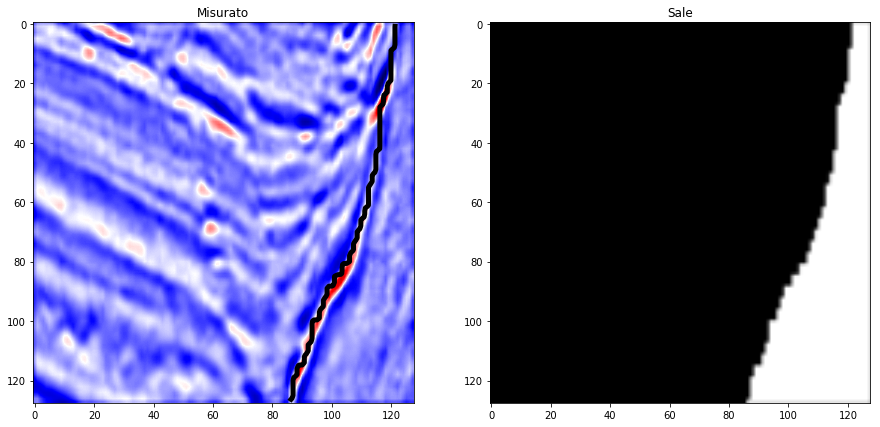

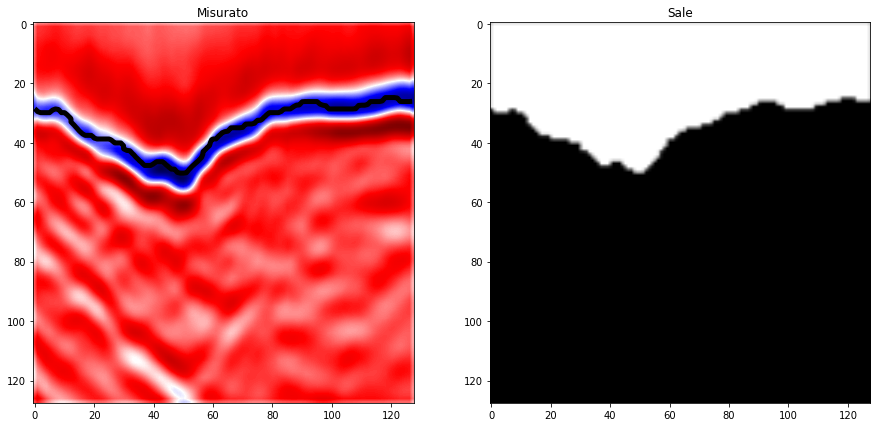

In [80]:

# definisco due indici a caso
ix1, ix2 = random.sample(range(1, len(X_train)), 2)

def plotta(X, y):
    maschera = y.max() > 0 # se è maggiore di zero è presente sale

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

    ax1.imshow(X, cmap = 'seismic', interpolation = 'bilinear')
    if has_mask: # if salt
        # draw a boundary(contour) in the original image separating salt and non-salt areas
        ax1.contour(y.squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
    ax1.set_title('Misurato')

    ax2.imshow(y.squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Sale')

plotta(X_train[ix1, ..., 0], y_train[ix1])
plotta(X_train[ix2, ..., 0], y_train[ix2])

Effettivamente, ad occhio è difficile individuare le zone contenenti sale!

In [81]:
# definisco il mio modello
def build_model(input_layer, start_neurons):

    conv_1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv_1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    pool_1 = Dropout(0.5)(pool_1)


    conv_2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool_1)
    conv_2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
    pool_2 = Dropout(0.5)(pool_2)


    conv_3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool_2)
    conv_3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv_3)
    pool_3 = MaxPooling2D((2, 2))(conv_3)
    pool_3 = Dropout(0.5)(pool_3)

    conv_4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool_3)
    conv_4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv_4)
    pool_4 = MaxPooling2D((2, 2))(conv_4)
    pool_4 = Dropout(0.5)(pool_4)


    conv_m = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool_4)
    conv_m = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(conv_m)


    deconv_4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(conv_m)
    uconv_4 = concatenate([deconv_4, conv_4])
    uconv_4 = Dropout(0.5)(uconv_4)
    uconv_4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv_4)
    uconv_4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv_4)


    deconv_3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv_4)
    uconv_3 = concatenate([deconv_3, conv_3])
    uconv_3 = Dropout(0.5)(uconv_3)
    uconv_3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv_3)
    uconv_3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv_3)

    deconv_2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv_3)
    uconv_2 = concatenate([deconv_2, conv_2])
    uconv_2 = Dropout(0.5)(uconv_2)
    uconv_2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv_2)
    uconv_2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv_2)


    deconv_1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv_2)
    uconv_1 = concatenate([deconv_1, conv_1])
    uconv_1 = Dropout(0.5)(uconv_1)
    uconv_1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv_1)
    uconv_1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv_1)

    uconv_1 = Dropout(0.5)(uconv_1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv_1)
    
    return output_layer

input_layer = Input((img_altezza, img_altezza, 1))
output_layer = build_model(input_layer, 32)

In [82]:
model = Model(input_layer, output_layer)

In [83]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [84]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 128, 128, 32) 320         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_202 (Conv2D)             (None, 128, 128, 32) 9248        conv2d_201[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_50 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_202[0][0]                 
__________________________________________________________________________________________________
dropout_94

In [85]:
early_stopping = EarlyStopping(patience=10, verbose=1)     # mi fermo se non migliorano i risultati dopo 10 epoche
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)     # salvo solamente le configurazioni con val_loss più basso
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)   # modifico il learning rate se smetto di vedere miglioramenti

# qualche parametro
epochs = 200
batch_size = 32

Training della U-net

In [86]:
history = model.fit(X_train, y_train,
                    validation_data=[X_test, y_test], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 27s 4ms/step - loss: 0.5778 - acc: 0.7479 - val_loss: 0.5405 - val_acc: 0.7395

Epoch 00001: val_loss improved from inf to 0.54054, saving model to ./keras.model
Epoch 2/200
6400/6400 [==============================] - 23s 4ms/step - loss: 0.5064 - acc: 0.7666 - val_loss: 0.5432 - val_acc: 0.7395

Epoch 00002: val_loss did not improve from 0.54054
Epoch 3/200
6400/6400 [==============================] - 23s 4ms/step - loss: 0.4216 - acc: 0.8201 - val_loss: 0.3698 - val_acc: 0.8567

Epoch 00003: val_loss improved from 0.54054 to 0.36980, saving model to ./keras.model
Epoch 4/200
6400/6400 [==============================] - 23s 4ms/step - loss: 0.3685 - acc: 0.8554 - val_loss: 0.3458 - val_acc: 0.8585

Epoch 00004: val_loss improved from 0.36980 to 0.34579, saving model to ./keras.model
Epoch 5/200
6400/6400 [==============================] - 23s 4ms/step - loss: 0.3248 - acc: 0.8740 -

**Non male**<br/>
Rappresento i risultati ottenuti!

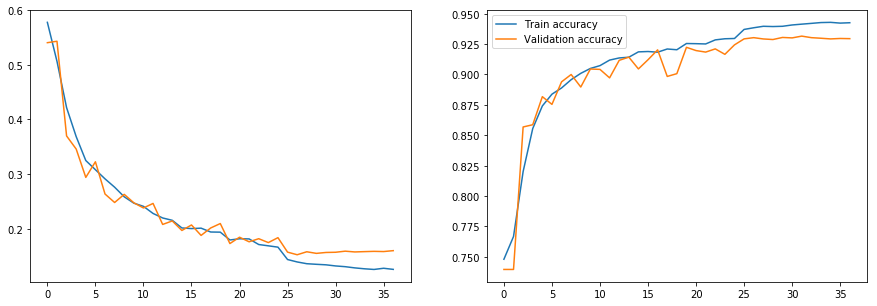

In [87]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
plt.legend()
plt.show()

Sembra che i dati convergano in modo corretto<br/>
Carico i pesi ottenuti

In [89]:
model.evaluate(X_test, y_test, verbose=1)

800/800 [==============================] - 1s 1ms/step


[0.15978526294231415, 0.9293460083007813]

In [90]:
# Applico al dataset di training e di test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

800/800 [==============================] - 1s 1ms/step


In [91]:
# Necessari per trasformare il risultato ottenuto in bianco e nero
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

Definisco una funzione per mostrare i risultati

In [106]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    
    if ix is None:
        ix = random.randint(0, len(X))

    maschera = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if maschera:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sismica_misurato')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Sale_misurato')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if maschera:
        ax[2].contour(y[ix].squeeze(), linewidth = 8 , colors='r', levels=[0.5])
    ax[2].set_title('Sale Predetto')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if maschera:
        ax[3].contour(y[ix].squeeze(), linewidth = 8,colors='r', levels=[0.5])
    ax[3].set_title('Sale Predetto binario');

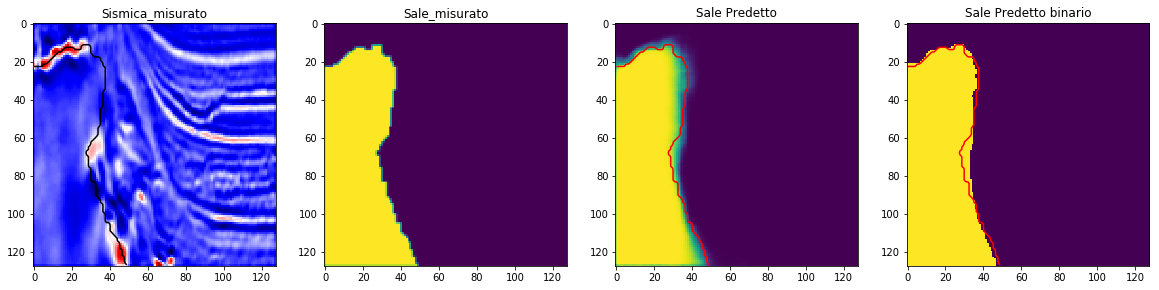

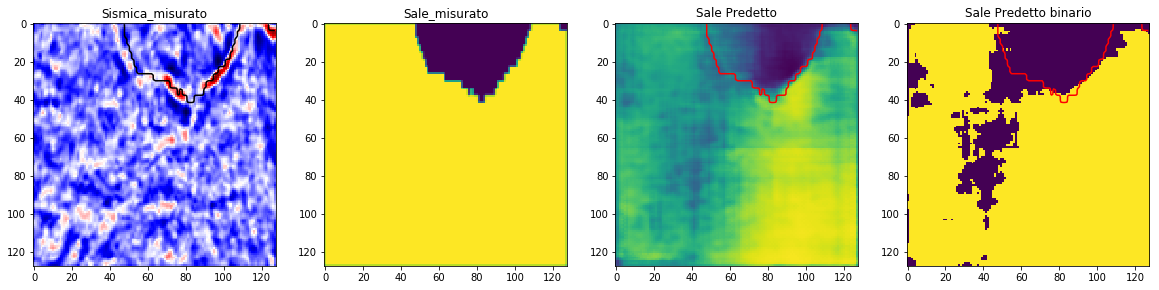

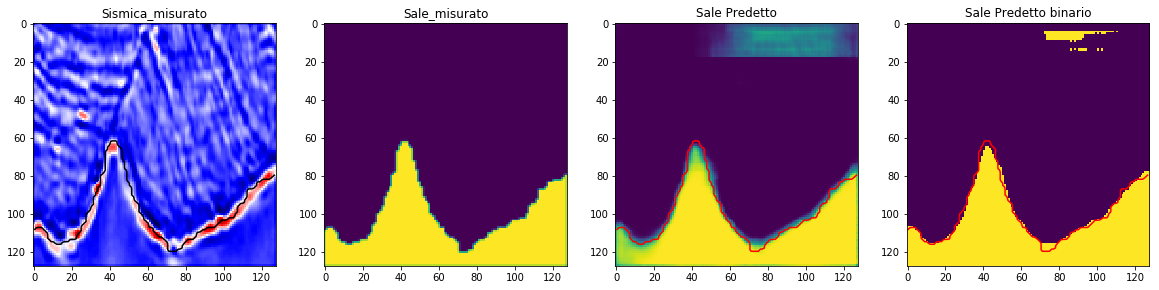

In [107]:
import random
for i in random.sample(range(1, len(X_train)), 3):
    plot_sample(X_train, y_train, preds_train, preds_train_t, ix=i)

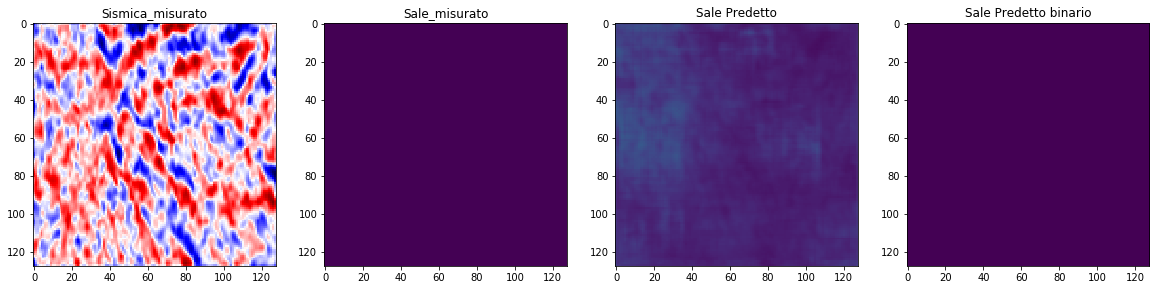

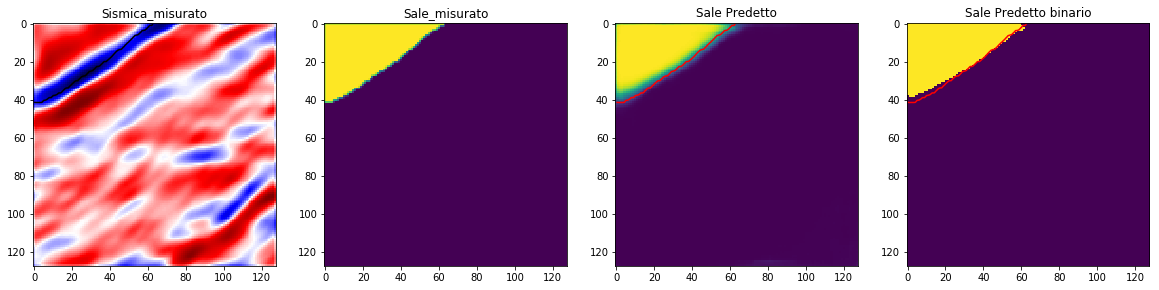

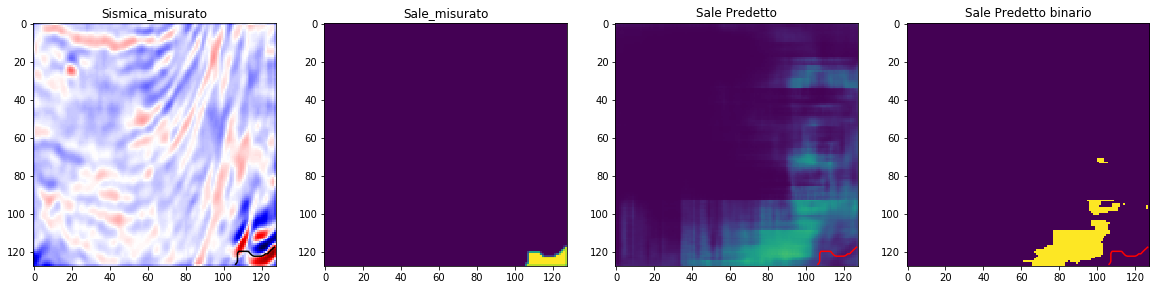

In [108]:
import random
for i in random.sample(range(1, len(X_test)), 3):
    plot_sample(X_test, y_test, preds_val, preds_val_t, ix=i)
